# **라이브러리**

In [1]:
!pip install koreanize-matplotlib

In [2]:
!pip install konlpy

In [3]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 48.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import koreanize_matplotlib

In [5]:
import pandas as pd
from konlpy.tag import Okt
from collections import Counter
import itertools
import networkx as nx
import matplotlib.pyplot as plt

# **데이터 병합 (박물관)**

In [6]:
import pandas as pd

# 파일 경로
file_paths = [
    "/content/drive/MyDrive/tour/크롤링/박물관/andong_museum.csv",
    "/content/drive/MyDrive/tour/크롤링/박물관/andong_village.csv",
    "/content/drive/MyDrive/tour/크롤링/박물관/gyeongju_museum.csv"
]

# 각 CSV 파일 불러오기
df_list = [pd.read_csv(path) for path in file_paths]

# 하나로 합치기
review = pd.concat(df_list, ignore_index=True)
display(review)


,review
0,The visit is relatively quick and interesting ...
1,The focus on Hahoe Masks could be amplified. T...
2,Free museum. Small museum to absolutely visit ...
3,I thought it would be a simple Korean traditio...
4,This museum is near to the ticket office of Ha...
...,...
524,This is a great museum. It's small enough to g...
525,When travelling around South Korea there are m...
526,I had a beautiful afternoon in Gyeongju gettin...
527,Excellent museum with lots of fascinating exhi...


# **명사**

## **명사쌍을 이용한 의미연결망**

In [7]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_nouns_spacy(text):
    try:
        doc = nlp(text.lower())
        nouns = [token.text for token in doc if token.pos_ == "NOUN" and not token.is_stop and token.is_alpha]
        return nouns
    except:
        return []


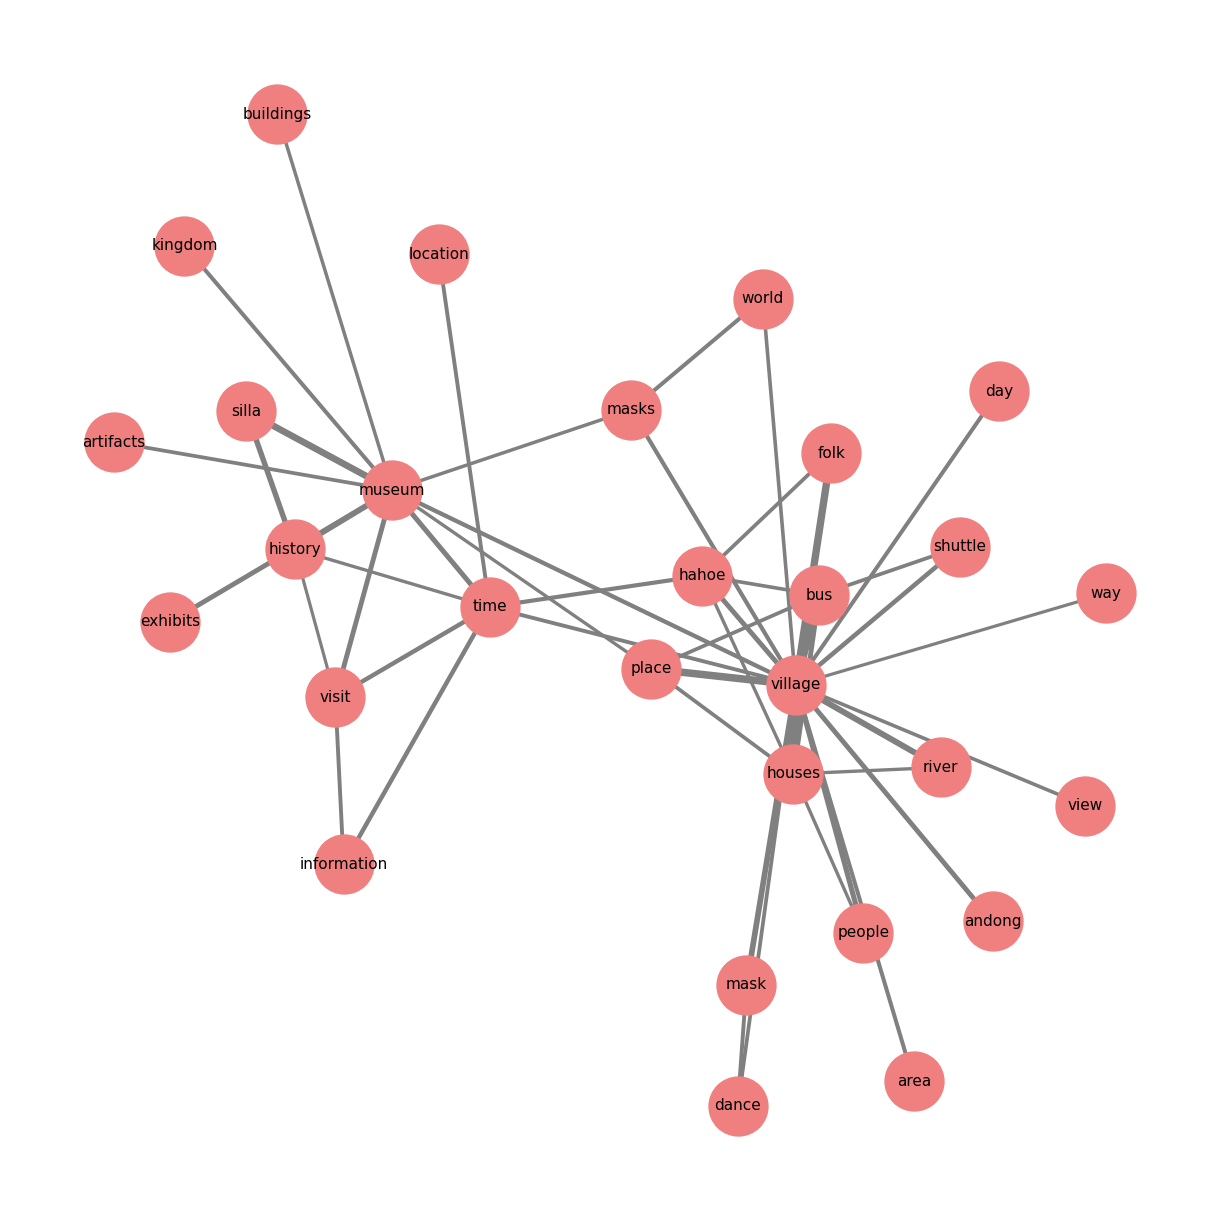

In [8]:
import itertools
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

# 명사 추출 적용
review['nouns'] = review['review'].apply(extract_nouns_spacy)

# 공출현 쌍 생성
co_occurrence = []
for nouns in review['nouns']:
    pairs = list(itertools.combinations(set(nouns), 2))
    co_occurrence.extend(pairs)

# 상위 50개 명사쌍
pair_counts = Counter(co_occurrence)
top_pairs = pair_counts.most_common(50)

# 그래프 생성 및 시각화
G = nx.Graph()
for (a, b), weight in top_pairs:
    G.add_edge(a, b, weight=weight)

pos = nx.spring_layout(G, k=0.5)
plt.figure(figsize=(12, 12))
nx.draw(G, pos,
        with_labels=True,
        node_color='lightcoral',
        node_size=1800,
        font_size=11,
        width=[G[u][v]['weight'] * 0.1 for u, v in G.edges()],  # ★ 수정: 1.2 → 0.3
        edge_color='gray')

## **커뮤니티를 접목한 의미연결망**

1. 커뮤니티란?
- 의미 연결망에서 ‘서로 밀접하게 연결된 단어 집단’을 자동으로 분류한 것
- 네트워크 그래프 안에서 노드(단어)들이 내부적으로 더 자주 연결되고 외부와는 적게 연결되는 집단
  - 서로 많이 공출현한 단어들끼리 같은 커뮤니티로 묶이고
  - 서로 거의 연결되지 않은 단어들은 다른 커뮤니티로 나뉜다.

In [9]:
!pip install python-louvain

In [10]:
import community.community_louvain as community_louvain

# Louvain 커뮤니티 탐색
partition = community_louvain.best_partition(G)

# 노드별 커뮤니티 번호를 색상으로 매핑
node_colors = [partition[node] for node in G.nodes()]

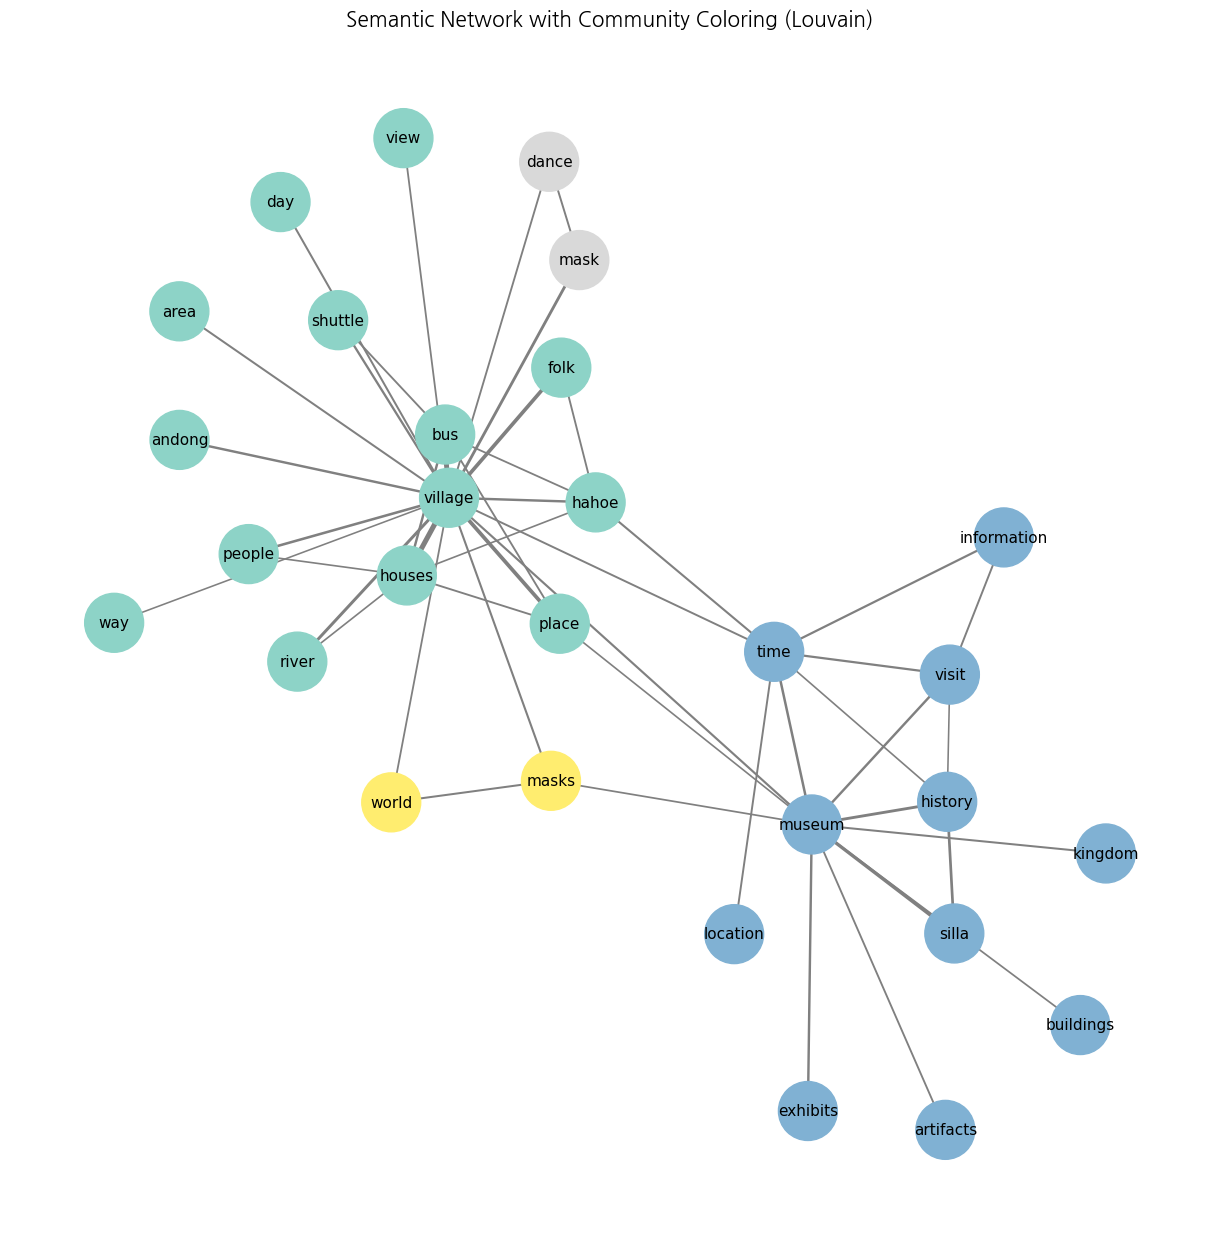

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# 그래프 레이아웃 고정
pos = nx.spring_layout(G, k=0.5, seed=42)

# 시각화
plt.figure(figsize=(12, 12))
nx.draw(G, pos,
        with_labels=True,
        node_color=node_colors,        # 커뮤니티별 색상
        cmap=plt.cm.Set3,              # 색상 맵 (Set1, Set2, Set3 등 가능)
        node_size=1800,
        font_size=11,
        width=[G[u][v]['weight'] * 0.05 for u, v in G.edges()],
        edge_color='gray')
plt.title("Semantic Network with Community Coloring (Louvain)", fontsize=15)
plt.show()

## **커뮤니티별 키워드 요약**

In [12]:
from collections import defaultdict

# 1. 커뮤니티별 노드 분류
community_dict = defaultdict(list)
for node, comm_id in partition.items():
    community_dict[comm_id].append(node)

# 2. 커뮤니티별 중심 노드 출력 (Degree 기준)
print("커뮤니티별 대표 키워드:")
for comm_id, nodes in community_dict.items():
    subgraph = G.subgraph(nodes)
    degree_centrality = nx.degree_centrality(subgraph)
    top_keywords = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\n[Community {comm_id}]")
    for word, score in top_keywords:
        print(f" - {word} (degree: {score:.2f})")


커뮤니티별 대표 키워드:

[Community 0]
 - village (degree: 1.00)
 - houses (degree: 0.46)
 - bus (degree: 0.38)
 - hahoe (degree: 0.31)
 - place (degree: 0.23)

[Community 1]
 - museum (degree: 0.80)
 - time (degree: 0.50)
 - history (degree: 0.40)
 - visit (degree: 0.40)
 - silla (degree: 0.20)

[Community 2]
 - dance (degree: 1.00)
 - mask (degree: 1.00)

[Community 3]
 - world (degree: 1.00)
 - masks (degree: 1.00)


## **중심성 순위 정리 (전체 네트워크 기준)**

In [13]:
# 전체 네트워크 중심성 계산
centrality = nx.degree_centrality(G)

# 상위 10개 중심 단어
top_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("📌 전체 네트워크 중심 단어 TOP 10:")
for word, score in top_central:
    print(f" - {word}: {score:.3f}")

📌 전체 네트워크 중심 단어 TOP 10:
 - village: 0.679
 - museum: 0.393
 - time: 0.250
 - houses: 0.214
 - bus: 0.179
 - hahoe: 0.179
 - place: 0.143
 - history: 0.143
 - visit: 0.143
 - masks: 0.107


## **워드클라우드**

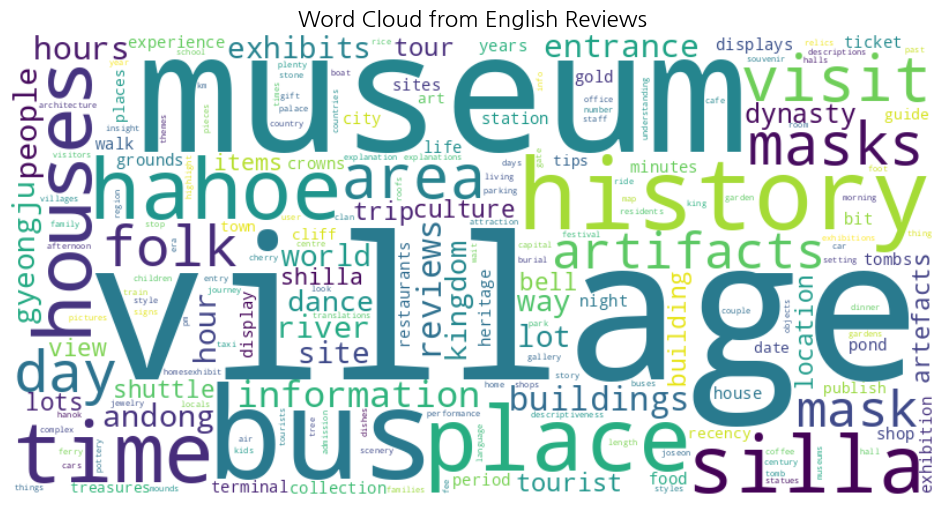

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 단어별 등장 횟수 계산
all_nouns = review['nouns'].sum()
noun_counts = Counter(all_nouns)

# 워드클라우드 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(noun_counts)

# 시각화
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud from English Reviews", fontsize=16)
plt.show()


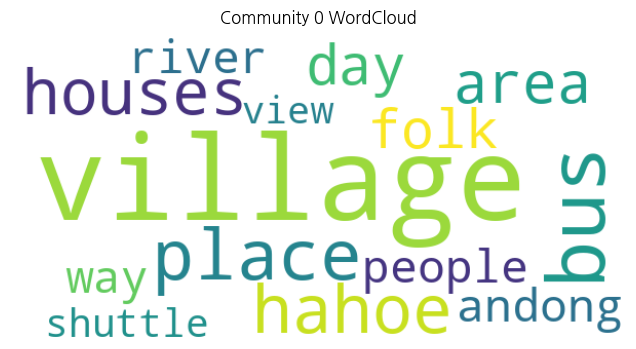

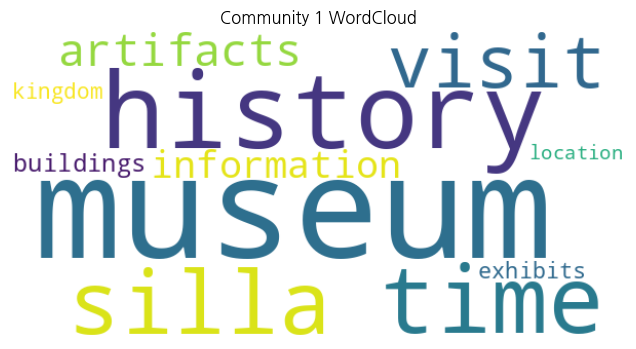

In [15]:
for comm_id, nodes in community_dict.items():
    comm_nouns = [noun for noun_list in review['nouns'] for noun in noun_list if noun in nodes]
    comm_counts = Counter(comm_nouns)
    if len(comm_counts) < 3: continue  # 너무 적으면 생략

    wc = WordCloud(width=600, height=300, background_color='white').generate_from_frequencies(comm_counts)
    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Community {comm_id} WordCloud")
    plt.show()


# **명사+동사+형용사**

## **의미연결망**

### 키워드 추출 함수

In [16]:
def extract_keywords_spacy(text):
    try:
        doc = nlp(text.lower())
        # 명사(NOUN), 동사(VERB), 형용사(ADJ) 포함
        return [token.text for token in doc
                if token.pos_ in ["NOUN", "VERB", "ADJ"]
                and not token.is_stop
                and token.is_alpha]
    except:
        return []

### 공출현 쌍 생성 및 네트워크 생성

In [17]:
# 키워드 적용
review['keywords'] = review['review'].apply(extract_keywords_spacy)

# 공출현 쌍
co_occurrence = []
for words in review['keywords']:
    pairs = list(itertools.combinations(set(words), 2))
    co_occurrence.extend(pairs)

# 빈도 계산
pair_counts = Counter(co_occurrence)
top_pairs = pair_counts.most_common(50)

# 그래프 생성
G = nx.Graph()
for (a, b), weight in top_pairs:
    G.add_edge(a, b, weight=weight)

# Louvain 커뮤니티
import community.community_louvain as community_louvain
partition = community_louvain.best_partition(G)
node_colors = [partition[n] for n in G.nodes()]


### 시각화

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


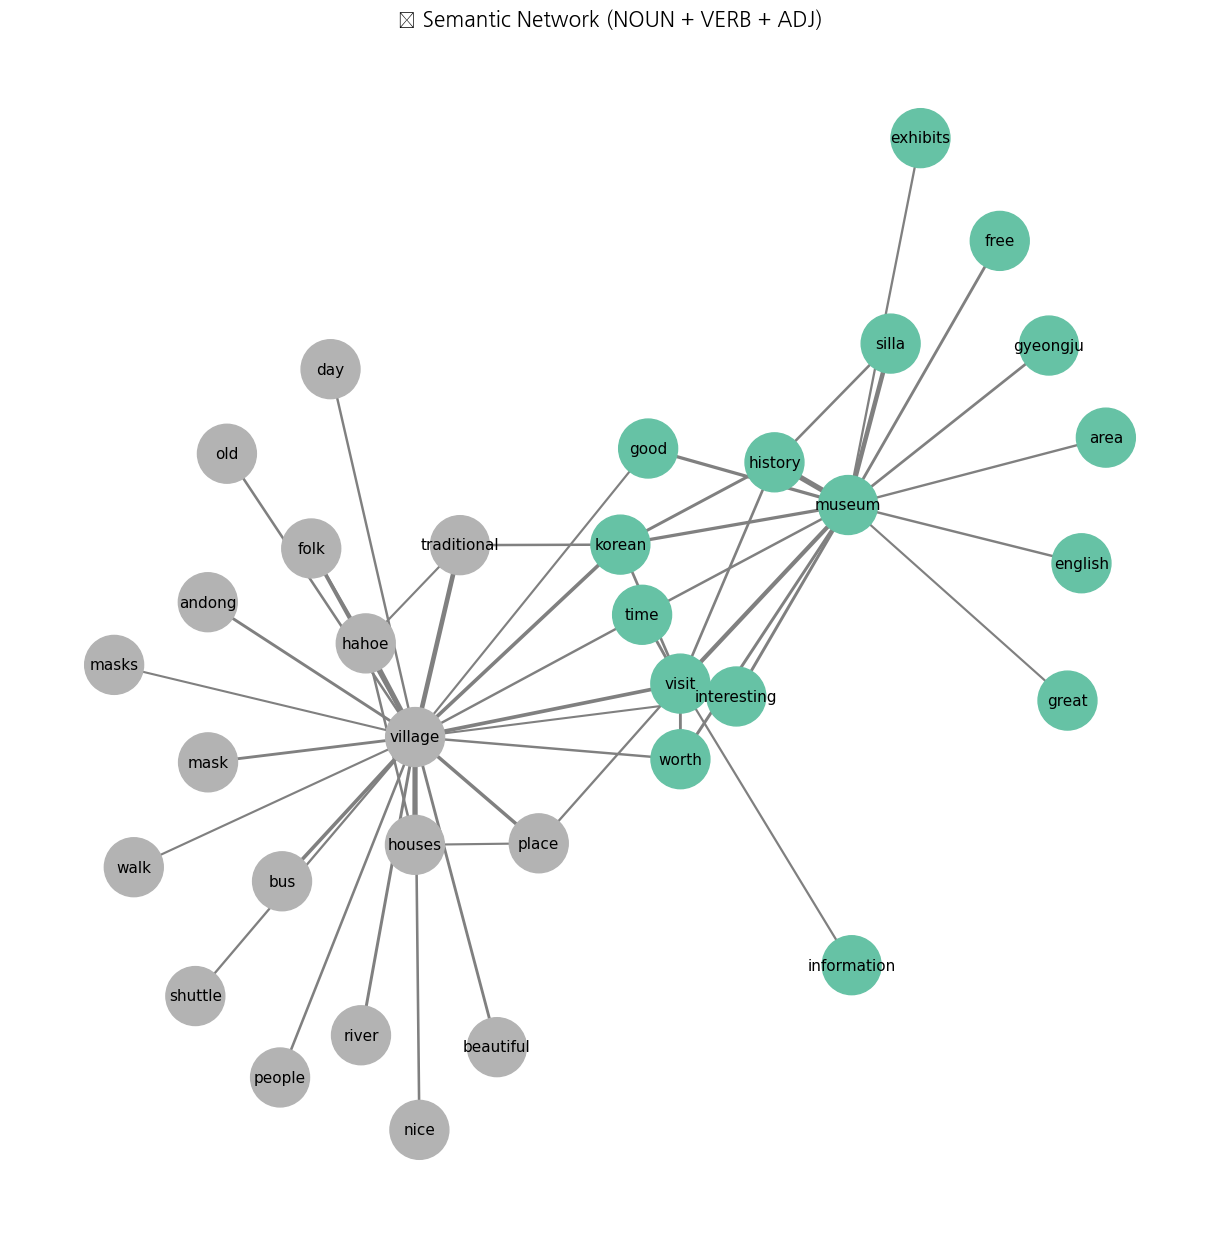

In [18]:
pos = nx.spring_layout(G, k=0.5, seed=42)
plt.figure(figsize=(12, 12))
nx.draw(G, pos,
        with_labels=True,
        node_color=node_colors,
        cmap=plt.cm.Set2,
        node_size=1800,
        font_size=11,
        width=[G[u][v]['weight'] * 0.05 for u, v in G.edges()],
        edge_color='gray')
plt.title("📘 Semantic Network (NOUN + VERB + ADJ)", fontsize=15)
plt.show()


## **워드클라우드**

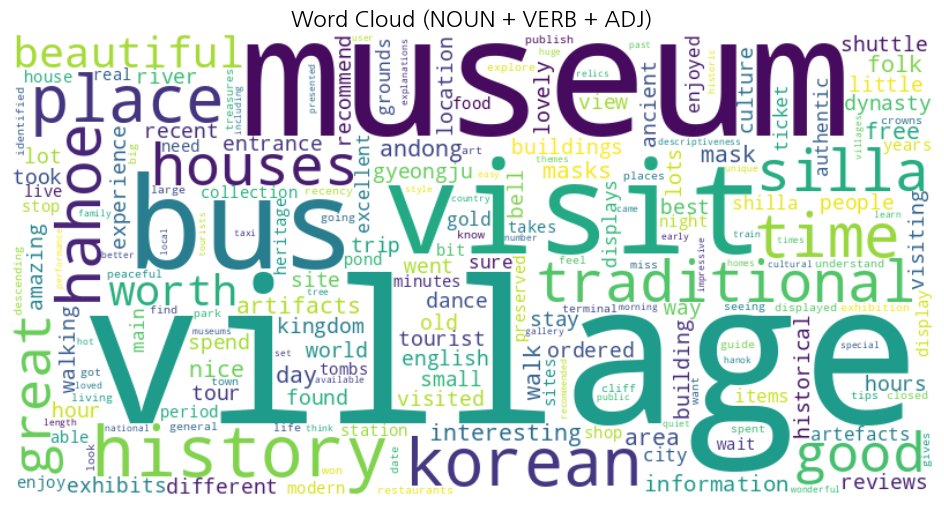

In [19]:
from wordcloud import WordCloud

# 전체 키워드 목록
all_keywords = review['keywords'].sum()
keyword_counts = Counter(all_keywords)

# 워드클라우드 생성
wordcloud = WordCloud(width=800, height=400, background_color='white',random_state=42).generate_from_frequencies(keyword_counts)

# 시각화
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud (NOUN + VERB + ADJ)", fontsize=16)
plt.show()


## **감정 분석**

###  감정 사전 준비 (NLTK Opinion Lexicon)

In [20]:
import nltk
nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon

positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())


[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


### 키워드 감정 분류

In [21]:
# 감정 분류
positive_counts = Counter([word for word in all_keywords if word in positive_words])
negative_counts = Counter([word for word in all_keywords if word in negative_words])

### 시각화

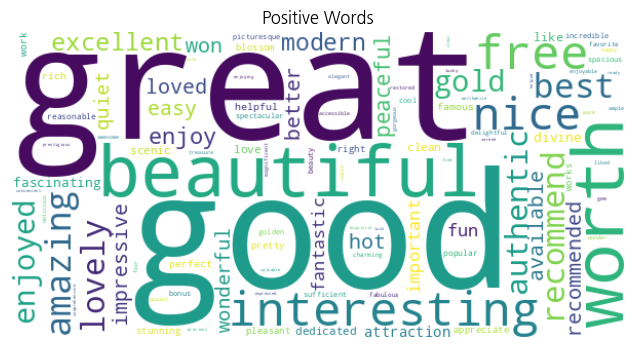

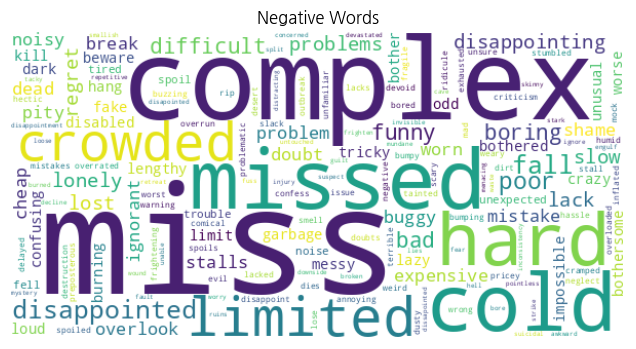

In [22]:
# 긍정 워드클라우드
pos_wc = WordCloud(width=600, height=300, background_color='white',random_state=42).generate_from_frequencies(positive_counts)
plt.figure(figsize=(8, 4))
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Words")
plt.show()

# 부정 워드클라우드
neg_wc = WordCloud(width=600, height=300, background_color='white',random_state=42).generate_from_frequencies(negative_counts)
plt.figure(figsize=(8, 4))
plt.imshow(neg_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Words")
plt.show()


## Step-by-Step: "miss" 포함 리뷰 추출 및 감정 분석
- 감정분석 - 부정에서 MISS의 뜻

### "miss" 키워드 포함 리뷰 추출

In [23]:
# miss 포함 여부 필터링 (대소문자 구분 없이)
miss_reviews = review[review['review'].str.contains(r'\bmiss\b', case=False, na=False)]

# 개수 확인
print(f"'miss' 포함 리뷰 수: {len(miss_reviews)}")

# 상위 5개 예시 출력
miss_reviews['review'].head()


'miss' 포함 리뷰 수: 23


,review
14,and try not to miss a mask dance performance i...
57,To do absolutely Village to absolutely see eve...
110,Easy to get to from Andong and VERY worth it! ...
125,Not a lot to see We were quite disappointed to...
157,Traditional firework during mask-dance-festiva...


### 감정 분류 (긍정/부정/중립 추정)

In [24]:
# 기본 부정 단서 단어 리스트
negative_clues = ['disappoint', 'bad', 'poor', 'cold', 'miss', 'boring', 'regret', 'worse', 'nothing']

def simple_sentiment(review_text):
    text = review_text.lower()
    if any(neg in text for neg in negative_clues):
        return 'negative'
    elif 'not miss' in text or "don't miss" in text:
        return 'positive'
    else:
        return 'neutral'

# 감정 컬럼 추가
miss_reviews['sentiment'] = miss_reviews['review'].apply(simple_sentiment)


/tmp/ipython-input-24-2512711037.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  miss_reviews['sentiment'] = miss_reviews['review'].apply(simple_sentiment)


### 감정 분포 확인

In [25]:
miss_reviews['sentiment'].value_counts()


,count
sentiment,
negative,23


### 실제 MISS가 포함된 리뷰 추출

(1) try not to miss a mask dance performance <br>

(2) Don't miss the 2 p.m. show. <br>

(3) try not to miss a mask dance <br>

(5) to make sure you do not miss the fireworks! <br>

→ 놓치지 마라! **즉, 긍정이지만 부정으로 분류됨**


(4) we would probably have given Andong a miss → **실제로 부정**

In [26]:
for idx, row in miss_reviews[['review', 'sentiment']].head(5).iterrows():
    print(f"[{row['sentiment'].upper()}] {row['review']}\n")


[NEGATIVE] and try not to miss a mask dance performance in Hahoe. fun and interesting. The area is lovely and the mask museum is quite extensive.

[NEGATIVE] To do absolutely Village to absolutely see even if it is very touristy. Don't miss the 2 p.m. show. Allow 2 hours for the visit to get a good look at the village.

[NEGATIVE] Easy to get to from Andong and VERY worth it!  utter charm Take the bus from the bus depot in Andong.  The village is magical and try not to miss a mask dance!!

[NEGATIVE] Not a lot to see We were quite disappointed to find the various buildings either unfurnished or closed off. Most travellers come to Andong to see this folk village. It would have been better if the buildings had been set up internally to show how life was long ago (which was portrayed so well in Suwon Palace, just outside of Seoul). There is a high up viewing point (rock) in the area reached by a private (chargeable) ferry followed by some walking up, but you would need a fair amount of ti

##  문맥 기반 감정 분석 모델 사용 - HuggingFace Transformers (정밀 딥러닝 기반)

In [27]:
!pip install transformers
!pip install torch

In [28]:
from transformers import pipeline

# 사전 훈련된 감정 분석 파이프라인 로딩
classifier = pipeline("sentiment-analysis")

# 문장이 너무 길면 앞부분만 사용 (문자 기준 512자)
review['review_truncated'] = review['review'].astype(str).apply(lambda x: x[:512])

# 감정 분석 적용
review['sentiment_transformer'] = review['review_truncated'].apply(lambda x: classifier(x)[0]['label'])

# 결과 확인
print(review['sentiment_transformer'].value_counts())


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


sentiment_transformer
POSITIVE    469
NEGATIVE     60
Name: count, dtype: int64


In [29]:
# spaCy 로드 (이미 로드했다면 생략)
import spacy
nlp = spacy.load("en_core_web_sm")

# 명사/동사/형용사 추출 함수
def extract_keywords(text):
    doc = nlp(str(text).lower())
    return [token.text for token in doc
            if token.pos_ in ['NOUN', 'VERB', 'ADJ']
            and not token.is_stop and token.is_alpha]


### 긍정/부정별 키워드 추출

In [30]:
# 긍정 리뷰 키워드
positive_reviews = review[review['sentiment_transformer'] == 'POSITIVE']['review']
positive_keywords = positive_reviews.apply(extract_keywords).sum()

# 부정 리뷰 키워드
negative_reviews = review[review['sentiment_transformer'] == 'NEGATIVE']['review']
negative_keywords = negative_reviews.apply(extract_keywords).sum()


In [31]:
from collections import Counter

positive_counts = Counter(positive_keywords)
negative_counts = Counter(negative_keywords)


### 워드클라우드 시각화

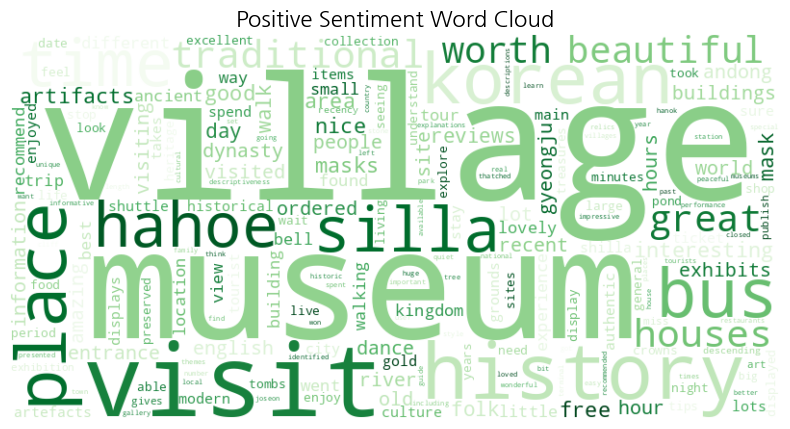

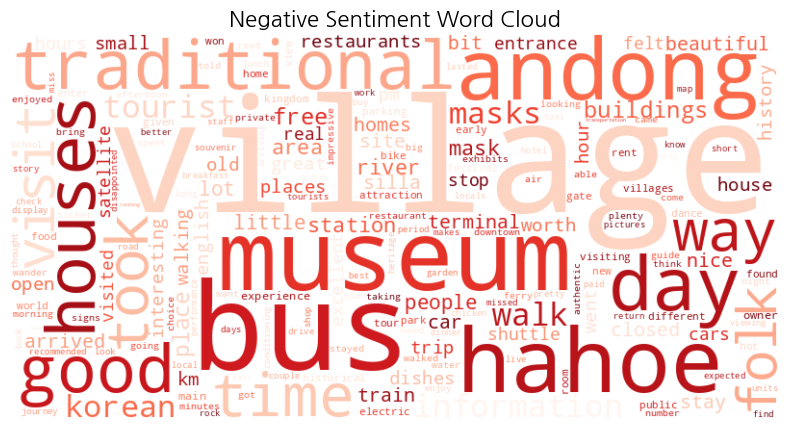

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# POSITIVE 워드클라우드
pos_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens')\
    .generate_from_frequencies(positive_counts)

plt.figure(figsize=(10, 5))
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Sentiment Word Cloud", fontsize=16)
plt.show()

# NEGATIVE 워드클라우드
neg_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds')\
    .generate_from_frequencies(negative_counts)

plt.figure(figsize=(10, 5))
plt.imshow(neg_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Sentiment Word Cloud", fontsize=16)
plt.show()


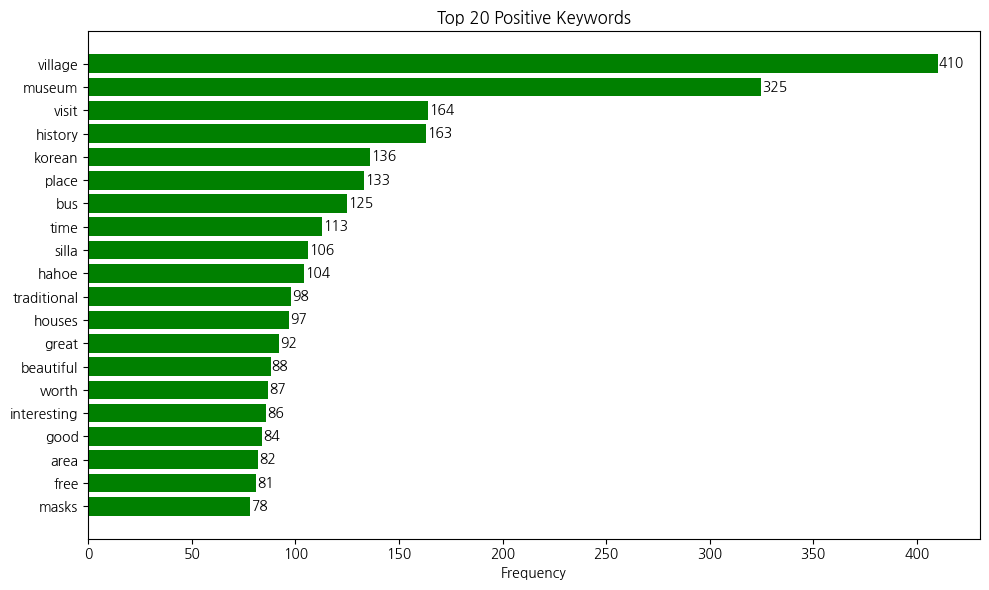

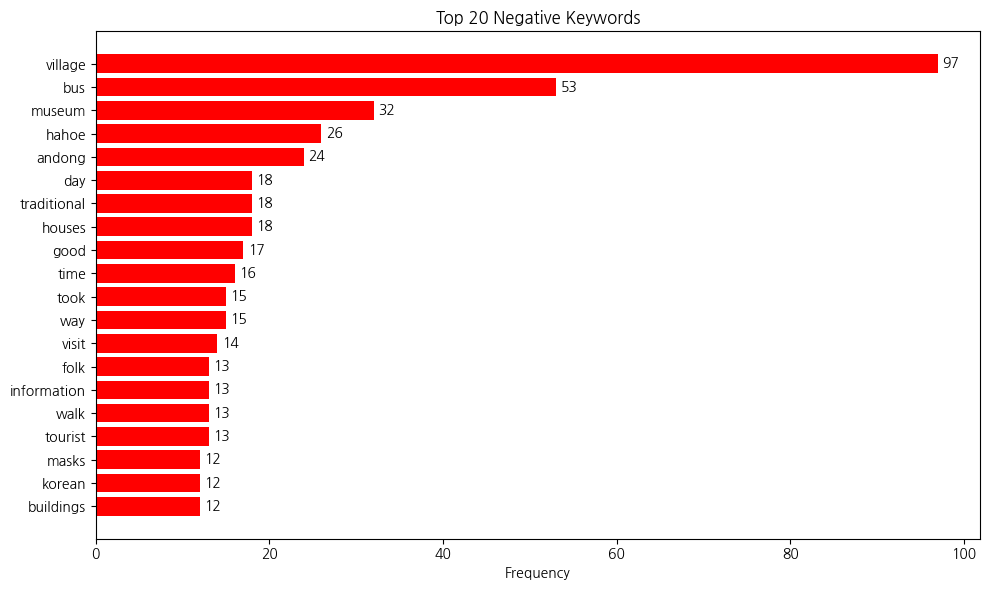

In [33]:
# 상위 20개 키워드 추출
top_pos = positive_counts.most_common(20)
top_neg = negative_counts.most_common(20)

# 데이터프레임으로 변환
df_pos = pd.DataFrame(top_pos, columns=['Keyword', 'Frequency'])
df_neg = pd.DataFrame(top_neg, columns=['Keyword', 'Frequency'])

# 시각화: 긍정 키워드
plt.figure(figsize=(10, 6))
bars = plt.barh(df_pos['Keyword'][::-1], df_pos['Frequency'][::-1], color='green')
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}', va='center')
plt.title("Top 20 Positive Keywords")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

# 시각화: 부정 키워드
plt.figure(figsize=(10, 6))
bars = plt.barh(df_neg['Keyword'][::-1], df_neg['Frequency'][::-1], color='red')
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}', va='center')
plt.title("Top 20 Negative Keywords")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

### 부정-bus

In [34]:
# 먼저 bus가 들어간 리뷰 필터링 (위에서 했던 것)
bus_reviews = review[review['review'].str.contains(r'\bbus\b', case=False, na=False)]

# 감정 컬럼 이름이 'sentiment_transformer'일 경우 사용
for idx, row in bus_reviews[['review', 'sentiment_transformer']].head(5).iterrows():
    print(f"[{row['sentiment_transformer'].upper()}] {row['review']}\n")


[POSITIVE] A delightful experience as the museum features masks used in performance not only in Korea but all over the world. Much of it is in English which is not very common so it was good getting detailed information on the origins of the masks used in Korean culture especially. A summary of the various performances, the storyline and characters was given. The 'yamban' (aristocrat) seemed to be used frequently as a figure of ridicule and criticism while the priest, old woman (usually wronged and ill-treated when the husband takes a concubine) and servants play important roles.
Masks from other cultures were also displayed and their significance explained. The Japanese Noh drama (video of dances) was succinctly explained while the significance of the lion in chasing away evil spirits in Chinese folklore was pointed out. Southeast Asian dances with masks as in the Balinese Barong were discussed together with more remote regions like the Maldives, the South Pacific and Maori and Native

1. bus-부정
- The crazy mad bus driver took about 50minutes from downtown. We recommend hiring a bike once inside Hahoe. 10000 won for a regular bike all day or 20000 for an electric bike for 2hrs

-> 불친절한 기사, 장거리 이동, 정보 부족 등 불편사항 언급

✅ 1. 핵심 키워드 및 테마
- 긍정 리뷰 상위 키워드:
  - village, museum, visit, history,korean, silla, beautiful, worth 등.
  - 전통 문화(‘하회’, ‘마을’, ‘신라’, ‘한국적’)와 박물관 관람 자체에 대한 긍정적 경험을 반영.

- 부정 리뷰 상위 키워드:
  - village, bus, andong, shuttle, walk, time, information, took, tourist 등.
  - 주로 이동 수단(버스, 셔틀), 도보 거리, 관광 정보 부족 관련 불만이 많음.

✅ 2. 의미 연결망(Semantic Network)
- museum은 history, visit, korean, interesting, worth 등 긍정적 키워드와 연결되어 있음.
- village, haho, andong, mask 등은 bus, walk, shuttle과 같이 이동 관련 키워드와 함께 클러스터 형성 → 접근성 이슈를 반영할 가능성.

✅ 3. 감정(감성) 분석 결과
- 전반적으로 긍정 리뷰 비중이 높음, 특히 박물관 콘텐츠에 대한 문화적 만족감이 크며,
- 부정 리뷰는 접근성 문제(ex. 셔틀버스, 도보 이동) 및 편의시설 부족에 집중됨.

✅ 4. 워드클라우드 시각화 요약
- 긍정 워드클라우드에서는 ‘beautiful’, ‘worth’, ‘interesting’, ‘great’ 등 정서 긍정 키워드가 많이 나타남.
- 부정 워드클라우드에서는 ‘bus’, ‘walk’, ‘took’, ‘way’, ‘information’ 등 불편함을 표현하는 키워드가 분산되어 있음.

# **데이터 병합 (유적지)**

In [36]:
import pandas as pd

# 파일 경로
file_paths_historic = [
    "/content/drive/MyDrive/관광공모전/historic_site.csv"
]

# 각 CSV 파일 불러오기
df_list_historic = [pd.read_csv(path) for path in file_paths_historic]

# 하나로 합치기
review_historic = pd.concat(df_list_historic, ignore_index=True)
display(review_historic)

,review
0,Most Recent:Reviews ordered by most recent pub...
1,Rental cycle recommended It's a World Heritage...
2,Updated Andong and Hahoe Transport Oct 2024 Th...
3,A gem of a folk village Andong Hahoe Village i...
4,Do not walk. Rent an electric bike.
...,...
475,well preserved large complex of historic struc...
476,Historically place Must go there in April and ...
477,Fascinating temple in lovely setting This was ...
478,Well worth a visit Gyeongju is a very attracti...


# **명사+동사+형용사**

## **의미연결망**

### 키워드 추출 함수

In [37]:
def extract_keywords_spacy(text):
    try:
        doc = nlp(text.lower())
        # 명사(NOUN), 동사(VERB), 형용사(ADJ) 포함
        return [token.text for token in doc
                if token.pos_ in ["NOUN", "VERB", "ADJ"]
                and not token.is_stop
                and token.is_alpha]
    except:
        return []

### 공출현 쌍 생성 및 네트워크 생성

In [38]:
# 키워드 적용
review_historic['keywords'] = review_historic['review'].apply(extract_keywords_spacy)

# 공출현 쌍
co_occurrence_historic = []
for words in review_historic['keywords']:
    pairs = list(itertools.combinations(set(words), 2))
    co_occurrence_historic.extend(pairs)

# 빈도 계산
pair_counts_historic = Counter(co_occurrence_historic)
top_pairs_historic = pair_counts_historic.most_common(50)

# 그래프 생성
G_historic = nx.Graph()
for (a, b), weight in top_pairs_historic:
    G_historic.add_edge(a, b, weight=weight)

# Louvain 커뮤니티
import community.community_louvain as community_louvain
partition_historic = community_louvain.best_partition(G_historic)
node_colors_historic = [partition_historic[n] for n in G_historic.nodes()]


### 시각화

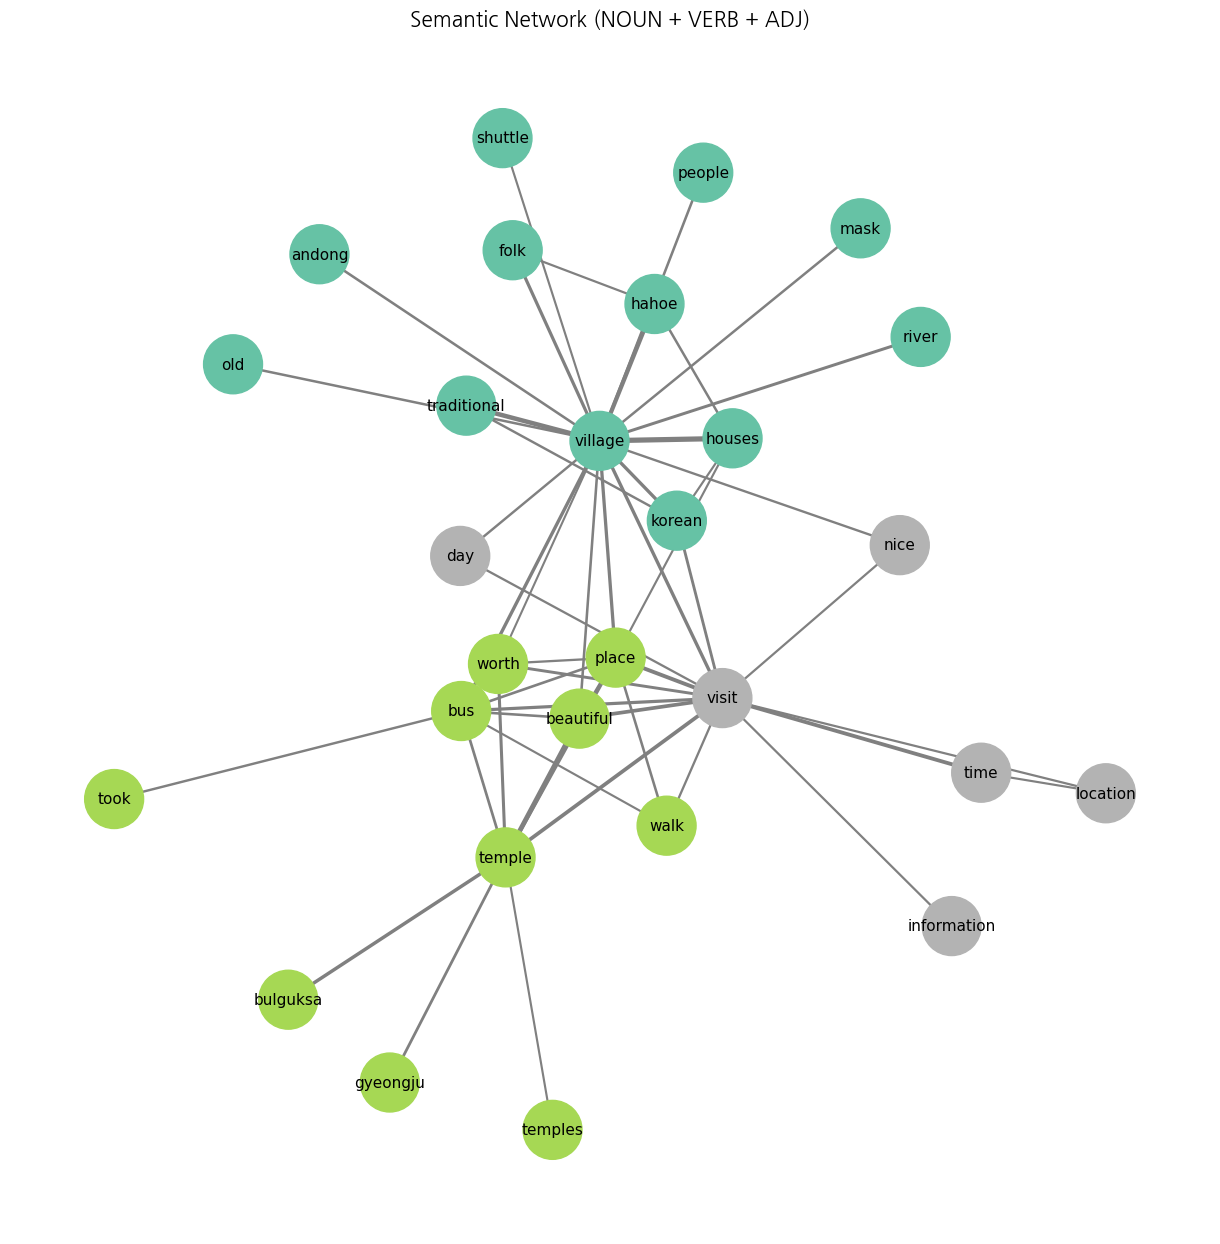

In [39]:
pos_historic = nx.spring_layout(G_historic, k=0.5, seed=42)  # 🔄 이 부분 수정
plt.figure(figsize=(12, 12))
nx.draw(
    G_historic,
    pos_historic,
    with_labels=True,
    node_color=node_colors_historic,
    cmap=plt.cm.Set2,
    node_size=1800,
    font_size=11,
    width=[G_historic[u][v]['weight'] * 0.05 for u, v in G_historic.edges()],  # 🔄 이 부분도 수정
    edge_color='gray'
)
plt.title("Semantic Network (NOUN + VERB + ADJ)", fontsize=15)
plt.show()


##  문맥 기반 감정 분석 모델 사용 - HuggingFace Transformers (정밀 딥러닝 기반)

In [40]:
# 문장이 너무 길면 앞부분만 사용
review_historic['review_truncated'] = review_historic['review'].astype(str).apply(lambda x: x[:512])

# 감정 분석 적용
review_historic['sentiment_transformer'] = review_historic['review_truncated'].apply(lambda x: classifier(x)[0]['label'])

# 결과 확인
print(review_historic['sentiment_transformer'].value_counts())


sentiment_transformer
POSITIVE    425
NEGATIVE     55
Name: count, dtype: int64


In [41]:
# 긍정 리뷰 키워드
positive_reviews = review_historic[review_historic['sentiment_transformer'] == 'POSITIVE']['review']
positive_keywords = positive_reviews.apply(extract_keywords).sum()

# 부정 리뷰 키워드
negative_reviews = review_historic[review_historic['sentiment_transformer'] == 'NEGATIVE']['review']
negative_keywords = negative_reviews.apply(extract_keywords).sum()

# Count
positive_counts = Counter(positive_keywords)
negative_counts = Counter(negative_keywords)


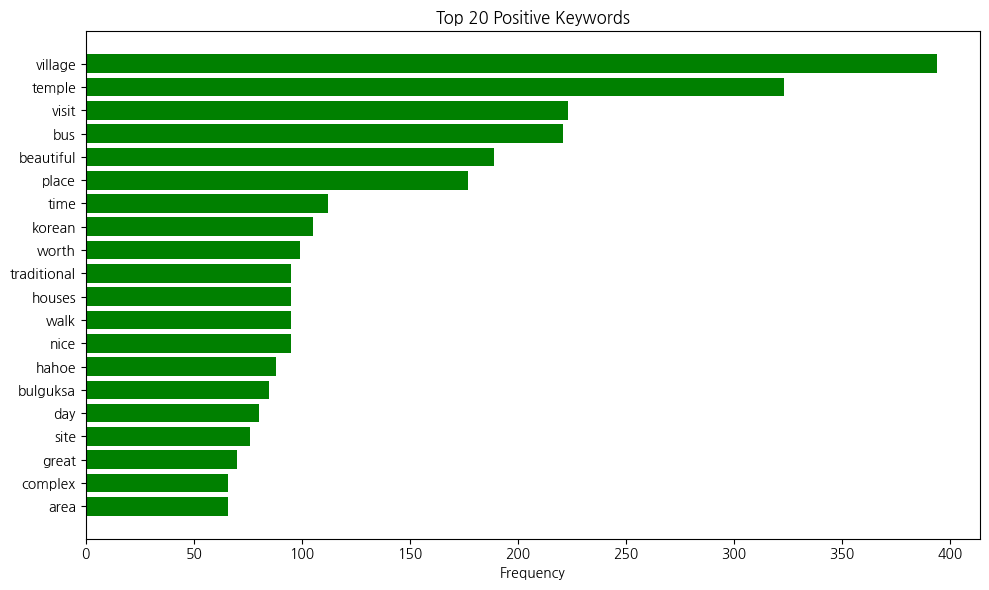

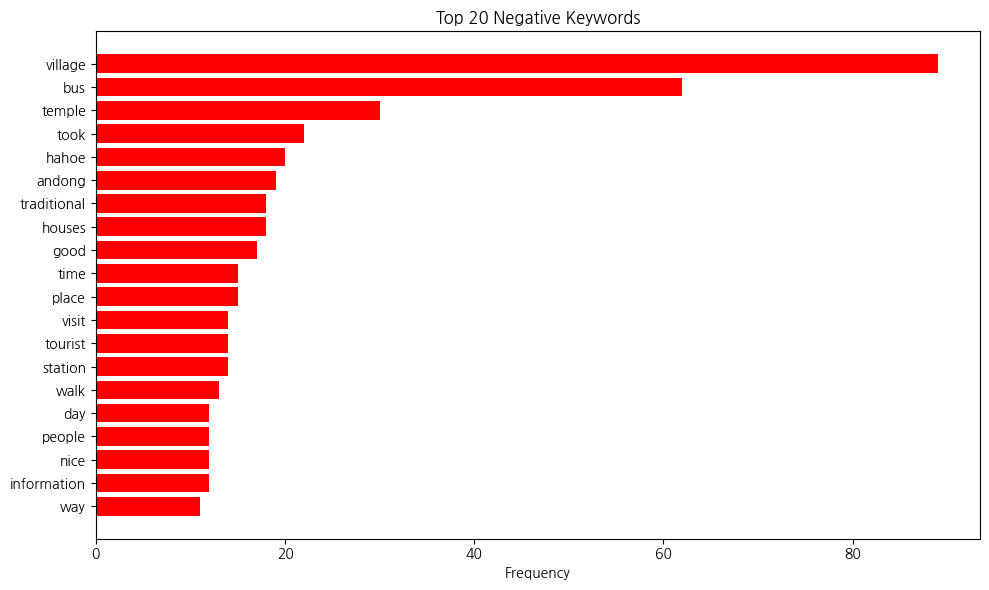

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 긍정 및 부정 키워드 Counter (이전 셀에서 추출했다고 가정)
positive_counts = Counter(positive_keywords)
negative_counts = Counter(negative_keywords)

# 상위 20개 키워드 추출
top_pos = positive_counts.most_common(20)
top_neg = negative_counts.most_common(20)

# 데이터프레임으로 변환
df_pos = pd.DataFrame(top_pos, columns=['Keyword', 'Frequency'])
df_neg = pd.DataFrame(top_neg, columns=['Keyword', 'Frequency'])

# 시각화: 긍정 키워드
plt.figure(figsize=(10, 6))
plt.barh(df_pos['Keyword'][::-1], df_pos['Frequency'][::-1], color='green')
plt.title("Top 20 Positive Keywords")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

# 시각화: 부정 키워드
plt.figure(figsize=(10, 6))
plt.barh(df_neg['Keyword'][::-1], df_neg['Frequency'][::-1], color='red')
plt.title("Top 20 Negative Keywords")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


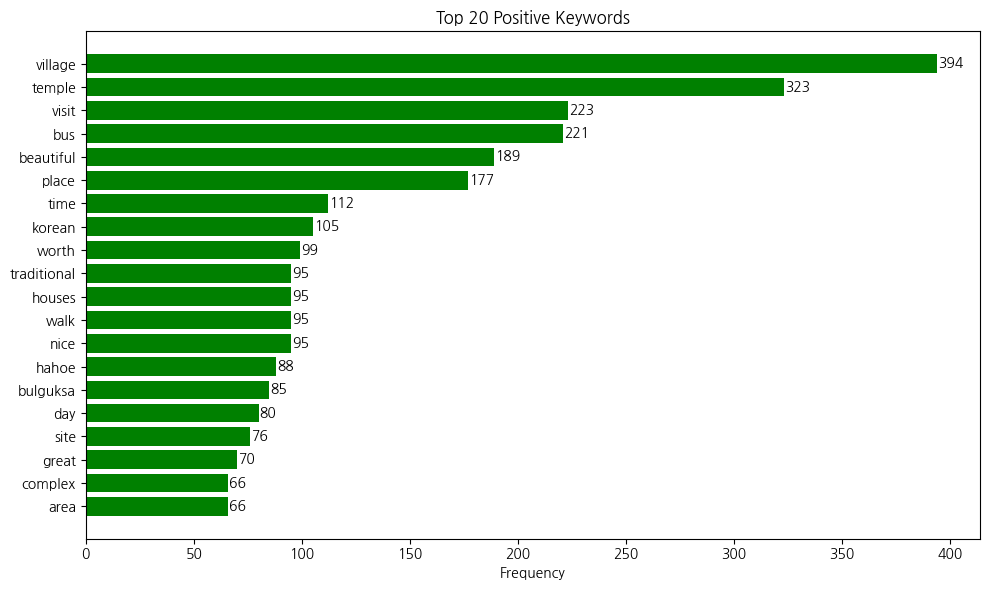

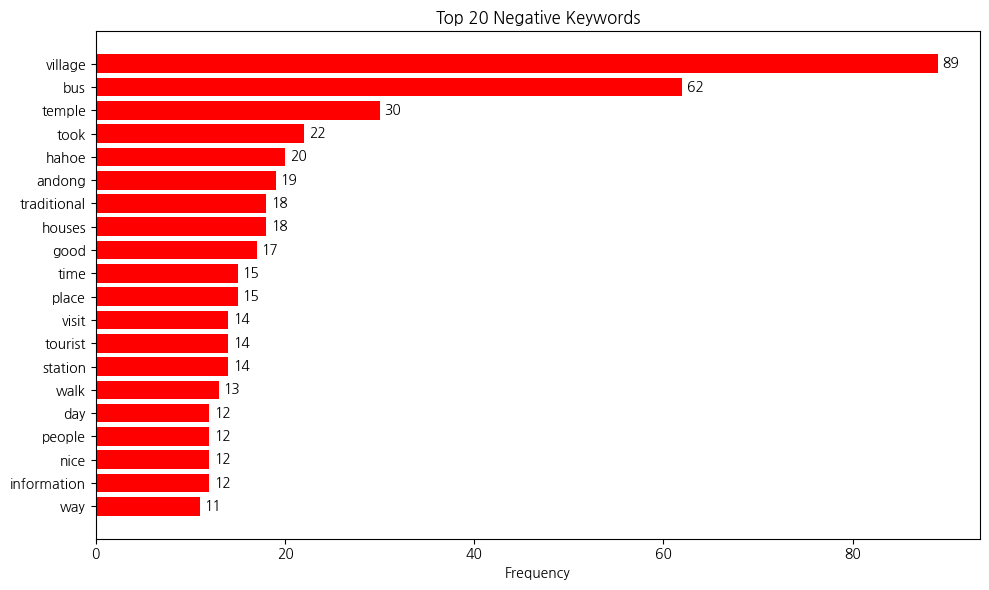

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 상위 20개 키워드 추출
top_pos = positive_counts.most_common(20)
top_neg = negative_counts.most_common(20)

# 데이터프레임으로 변환
df_pos = pd.DataFrame(top_pos, columns=['Keyword', 'Frequency'])
df_neg = pd.DataFrame(top_neg, columns=['Keyword', 'Frequency'])

# ✅ 시각화: 긍정 키워드
plt.figure(figsize=(10, 6))
bars = plt.barh(df_pos['Keyword'][::-1], df_pos['Frequency'][::-1], color='green')
plt.title("Top 20 Positive Keywords")
plt.xlabel("Frequency")

# 수치 표시
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
             f'{int(width)}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# ✅ 시각화: 부정 키워드
plt.figure(figsize=(10, 6))
bars = plt.barh(df_neg['Keyword'][::-1], df_neg['Frequency'][::-1], color='red')
plt.title("Top 20 Negative Keywords")
plt.xlabel("Frequency")

# 수치 표시
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
             f'{int(width)}', va='center', fontsize=10)

plt.tight_layout()
plt.show()
